In [1]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130

Looking in indexes: https://download.pytorch.org/whl/cu130
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached https://download.pytorch.org/whl/typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached https://download.pytorch.org/whl/jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached https://download.pytorch.org/whl/setuptools-70.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached numpy-2.3.5-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-2.1.5-cp313-cp313-win_amd64.whl
   ---------------------------------------- 0.0/1.9 GB ? eta -:--:--
   ---------------------------------------- 

In [2]:
%pip install pandas numpy scikit-learn nlpaug transformers sentencepiece

  Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.17.0-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-win_amd64.whl.metadata (7.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached charset_normalizer-3.4.4-cp313-cp313-win_amd64.whl.metadata (38 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached certifi-2026.1.4-py3-none-any.whl.metadata (2.5 kB)
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   ------ --------------------------------- 1.6/9.7 MB 5.7 MB/s eta 0:00:02
   ------------ ----

In [5]:
%pip install hf_xet

  Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl.metadata (5.0 kB)
Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl (2.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import nlpaug.augmenter.word as naw
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer
import tqdm

c:\Users\kuday\OneDrive\Документы\learning ml\projects\nlp\assignment4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
INPUT_FILE = 'merged_emotions_dataset.csv' 
TARGET_COUNT = 4000
MAX_COUNT = 8000
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print(DEVICE)

cuda


In [5]:
aug_bert = naw.ContextualWordEmbsAug(
    model_path='bert-base-multilingual-cased', 
    action="substitute", 
    device=DEVICE,
    aug_p=0.3
)

In [6]:
class MultilingualBackTranslator:
    def __init__(self, device='cpu'):
        self.device = device
        self.model_name = "facebook/m2m100_418M"
        self.tokenizer = M2M100Tokenizer.from_pretrained(self.model_name)
        self.model = M2M100ForConditionalGeneration.from_pretrained(self.model_name).to(device)

    def translate(self, texts, src_lang, tgt_lang):
        self.tokenizer.src_lang = src_lang
        
        encoded = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(self.device)
        
        generated_tokens = self.model.generate(
            **encoded, 
            forced_bos_token_id=self.tokenizer.get_lang_id(tgt_lang)
        )
        
        return self.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

    def augment(self, texts, source_lang_code):
        pivot_lang = 'fr' if source_lang_code == 'en' else 'en'
        
        try:
            pivot_texts = self.translate(texts, src_lang=source_lang_code, tgt_lang=pivot_lang)
            back_texts = self.translate(pivot_texts, src_lang=pivot_lang, tgt_lang=source_lang_code)
            return back_texts
        except Exception as e:
            print(f"Error augmenting lang {source_lang_code}: {e}")
            return texts

In [7]:
translator = MultilingualBackTranslator(device=DEVICE)

The following layers were not sharded: model.encoder.layers.*.self_attn.q_proj.weight, model.encoder.layers.*.fc*.bias, model.decoder.layers.*.encoder_attn_layer_norm.weight, model.decoder.layers.*.encoder_attn.k_proj.bias, model.decoder.layers.*.encoder_attn.q_proj.weight, lm_head.weight, model.decoder.layers.*.encoder_attn.v_proj.bias, model.encoder.layer_norm.bias, model.decoder.layers.*.encoder_attn.out_proj.weight, model.encoder.layers.*.self_attn.out_proj.bias, model.decoder.layers.*.final_layer_norm.weight, model.encoder.layers.*.self_attn.v_proj.weight, model.encoder.layers.*.self_attn.q_proj.bias, model.encoder.layers.*.self_attn_layer_norm.weight, model.decoder.layers.*.self_attn.k_proj.bias, model.decoder.layers.*.self_attn.k_proj.weight, model.decoder.layers.*.self_attn.v_proj.bias, model.decoder.layers.*.self_attn.q_proj.weight, model.decoder.layers.*.fc*.bias, model.encoder.layers.*.final_layer_norm.weight, model.encoder.embed_tokens.weight, model.encoder.layers.*.self_at

In [8]:
df = pd.read_csv(INPUT_FILE)
df_temp, df_test = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
df_train, df_val = train_test_split(df_temp, test_size=0.176, stratify=df_temp['label'], random_state=42)
print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Train: 43097, Val: 9206, Test: 9231


In [9]:
def balance_multilingual(group, label_name):
    count = len(group)
    
    if count > MAX_COUNT:
        return group.sample(n=MAX_COUNT, random_state=42)
        
    elif count < TARGET_COUNT:
        needed = TARGET_COUNT - count
        print(f"[{label_name}] Augmenting +{needed}...")
        
        new_rows = []
        samples = group.sample(n=needed, replace=True, random_state=42)
        
        for lang_code, lang_subset in samples.groupby('lang'):
            texts = lang_subset['text'].tolist()

            split_idx = len(texts) // 2
            bert_inputs = texts[:split_idx]
            trans_inputs = texts[split_idx:]

            for t in bert_inputs:
                try:
                    new_rows.append({'text': aug_bert.augment(t)[0], 'label': label_name, 'lang': lang_code})
                except:
                    new_rows.append({'text': t, 'label': label_name, 'lang': lang_code})

            batch_size = 8 
            for i in range(0, len(trans_inputs), batch_size):
                batch = trans_inputs[i : i+batch_size]
                aug_batch = translator.augment(batch, source_lang_code=lang_code)
                for t_aug in aug_batch:
                    new_rows.append({'text': t_aug, 'label': label_name, 'lang': lang_code})
        
        return pd.concat([group, pd.DataFrame(new_rows)])
    
    else:
        return group

In [10]:
balanced_groups = []
for label, group in tqdm.tqdm(df_train.groupby('label'), desc="Balancing classes"):
    balanced_groups.append(balance_multilingual(group, label))

df_train_balanced = pd.concat(balanced_groups).sample(frac=1, random_state=42).reset_index(drop=True)

df_train_balanced.to_csv('train_multilingual_balanced.csv', index=False)
df_val.to_csv('val.csv', index=False)
df_test.to_csv('test.csv', index=False)

Balancing classes:   0%|          | 0/5 [00:00<?, ?it/s]

[anger] Augmenting +837...


Balancing classes:  20%|██        | 1/5 [1:44:01<6:56:07, 6241.80s/it]

[fear] Augmenting +3672...


Balancing classes: 100%|██████████| 5/5 [8:04:20<00:00, 5812.09s/it]   


In [9]:
df_train_balanced = pd.read_csv('train_multilingual_balanced.csv')

<Axes: title={'center': 'Balanced Training Set Class Distribution'}, xlabel='label'>

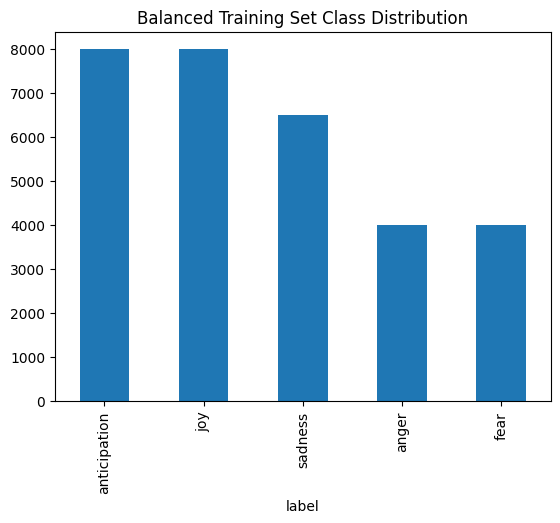

In [5]:
df_train_balanced['label'].value_counts().plot.bar(title='Balanced Training Set Class Distribution')

C:\Users\kuday\AppData\Local\Temp\ipykernel_5752\956110133.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='label', palette='viridis', order=order)


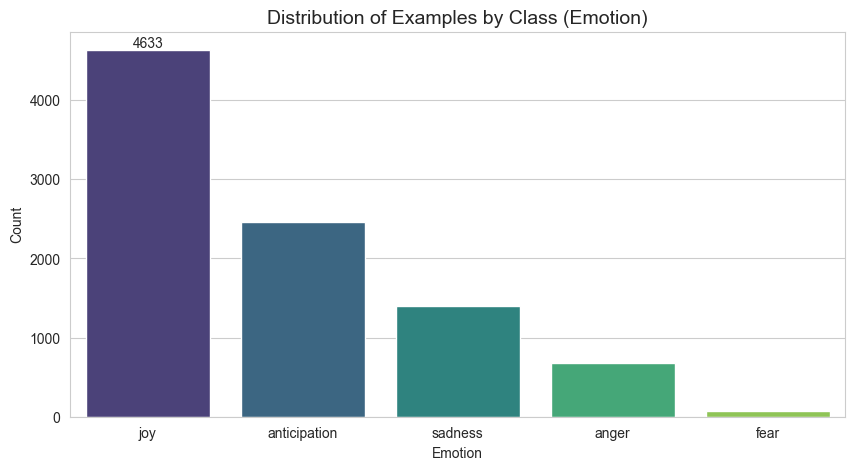

C:\Users\kuday\AppData\Local\Temp\ipykernel_5752\956110133.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='lang', palette='magma', order=lang_order)


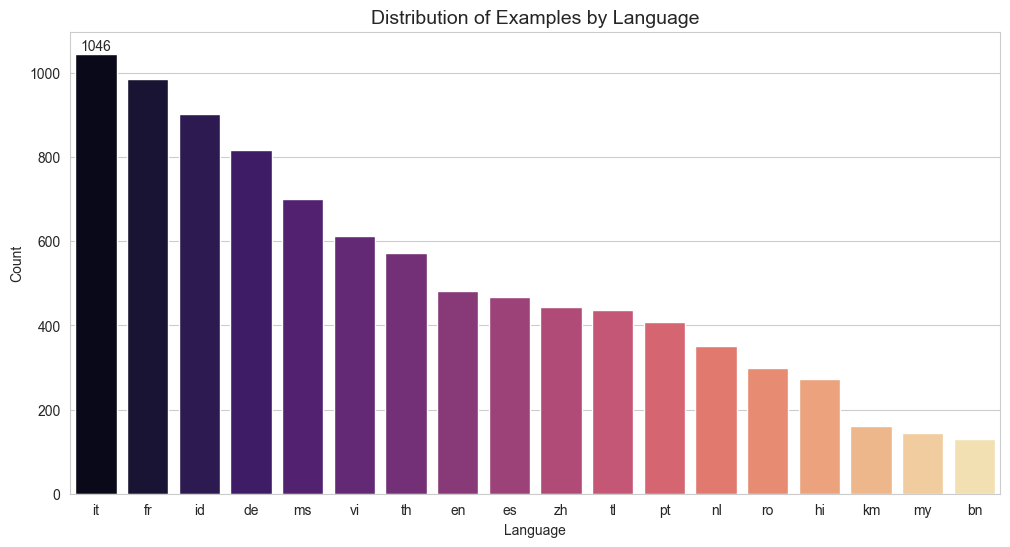

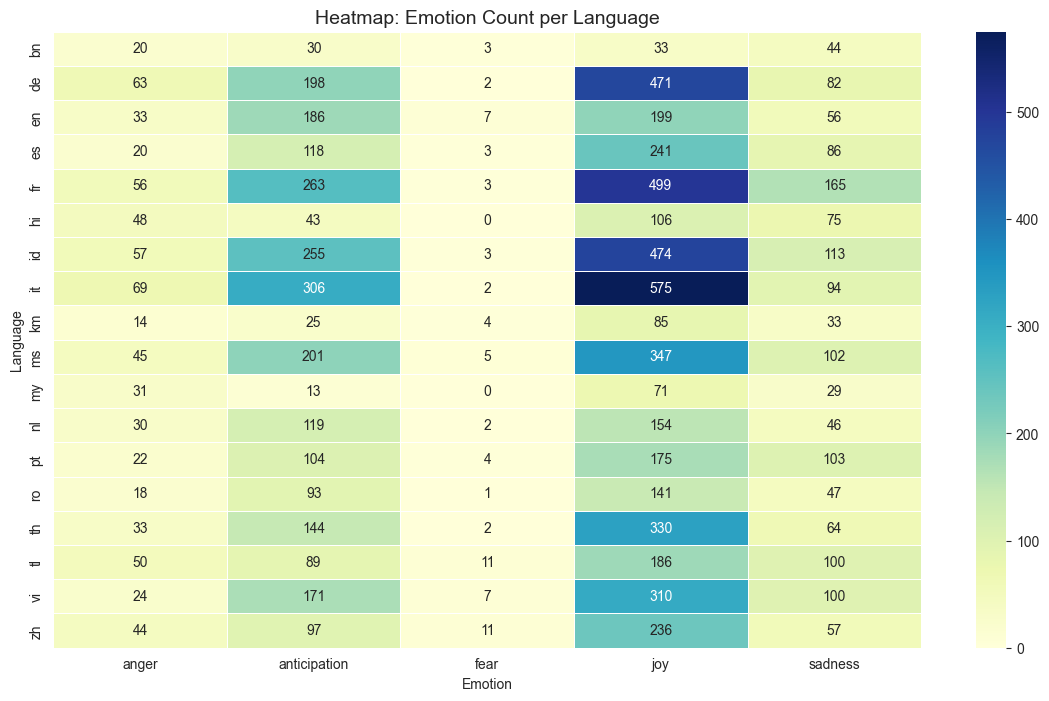


=== Top 3 Least Frequent Languages ===
lang
km    161
my    144
bn    130
Name: count, dtype: int64


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'test.csv'  
df = pd.read_csv(file_path)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

plt.figure(figsize=(10, 5))
order = df['label'].value_counts().index
ax = sns.countplot(data=df, x='label', palette='viridis', order=order)

plt.title('Distribution of Examples by Class (Emotion)', fontsize=14)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.bar_label(ax.containers[0]) 
plt.show()

plt.figure(figsize=(12, 6))
lang_order = df['lang'].value_counts().index
ax = sns.countplot(data=df, x='lang', palette='magma', order=lang_order)

plt.title('Distribution of Examples by Language', fontsize=14)
plt.xlabel('Language')
plt.ylabel('Count')
plt.bar_label(ax.containers[0])
plt.show()

plt.figure(figsize=(14, 8))
pivot_table = pd.crosstab(df['lang'], df['label'])

sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)

plt.title('Heatmap: Emotion Count per Language', fontsize=14)
plt.ylabel('Language')
plt.xlabel('Emotion')
plt.show()


print("\n=== Top 3 Least Frequent Languages ===")
print(df['lang'].value_counts().tail(3))
